In [739]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from PIL import Image

import modules.images.utils as im

In [740]:
# J'aimerais savoir la taille des images de notre dataset
taille_image = cv2.imread("./data-exploration/test/apple/0001.png")
taille_image.shape

(32, 32, 3)

In [741]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

TRAIN_DATA_DIR = './data-exploration/train'
TRAIN_IMAGE_SIZE = 32
TRAIN_BATCH_SIZE = 32

train_generator = image_data_generator.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='training')
    
validation_generator = image_data_generator.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

Found 2800 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [742]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(taille_image.shape)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(32, activation='elu'))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=3, activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(128, activation='elu'))
model.add(Dropout(0.2))


model.add(Conv2D(128, kernel_size=5, activation='elu', kernel_initializer='he_uniform', padding='same'))
model.add(Dense(256, activation='elu'))

#Toujours à la fin
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dense_155 (Dense)            (None, 16, 16, 32)        544       
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dense_156 (Dense)            (None, 8, 8, 64)        

In [743]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es_callback = EarlyStopping(monitor='val_loss', patience=3)

training = model.fit_generator(train_generator, epochs=20, callbacks=[es_callback], validation_data=validation_generator, shuffle=False)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/20
88/88 [==============================] - 52s 594ms/step - loss: 6.8736 - accuracy: 0.2564 - val_loss: 1.8000 - val_accuracy: 0.2443
Epoch 2/20
88/88 [==============================] - 33s 380ms/step - loss: 1.6120 - accuracy: 0.3964 - val_loss: 1.5239 - val_accuracy: 0.4186
Epoch 3/20
88/88 [==============================] - 34s 391ms/step - loss: 1.4751 - accuracy: 0.4364 - val_loss: 1.5581 - val_accuracy: 0.3857
Epoch 4/20
88/88 [==============================] - 37s 419ms/step - loss: 1.4175 - accuracy: 0.4611 - val_loss: 1.4866 - val_accuracy: 0.4357
Epoch 5/20
88/88 [==============================] - 41s 465ms/step - loss: 1.3378 - accuracy: 0.4886 - val_loss: 1.3578 - val_accuracy: 0.5114
Epoch 6/20
88/88 [==============================] - 37s 416ms/step - loss: 1.2607 - accuracy: 0.5211 - val_loss: 1.3771 - val_accuracy: 0.4800
Epoch 7/20
88/88 [==============================] 

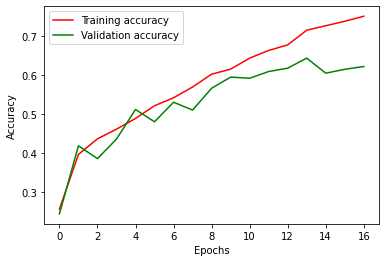

In [744]:
plt.plot(training.history['accuracy'], color='red', label='Training accuracy')
plt.plot(training.history['val_accuracy'],  color='green', label='Validation accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

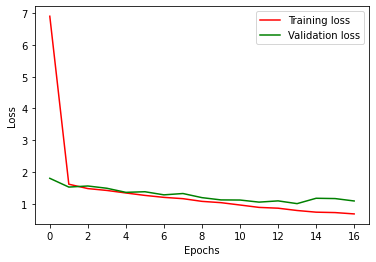

In [745]:
plt.plot(training.history['loss'], color='red', label='Training loss')
plt.plot(training.history['val_loss'],  color='green', label='Validation loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [746]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np

layer_outputs = [layer.output for layer in model.layers]

test_image = "./data-exploration/test/bear/0001.png"

# Le chargement de l'image doit être augmenté puisque notre model prend des lots d'images.
img = image.load_img(test_image, target_size=(32,32,3))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)

activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_arr)

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*13.5,col_size*2.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1

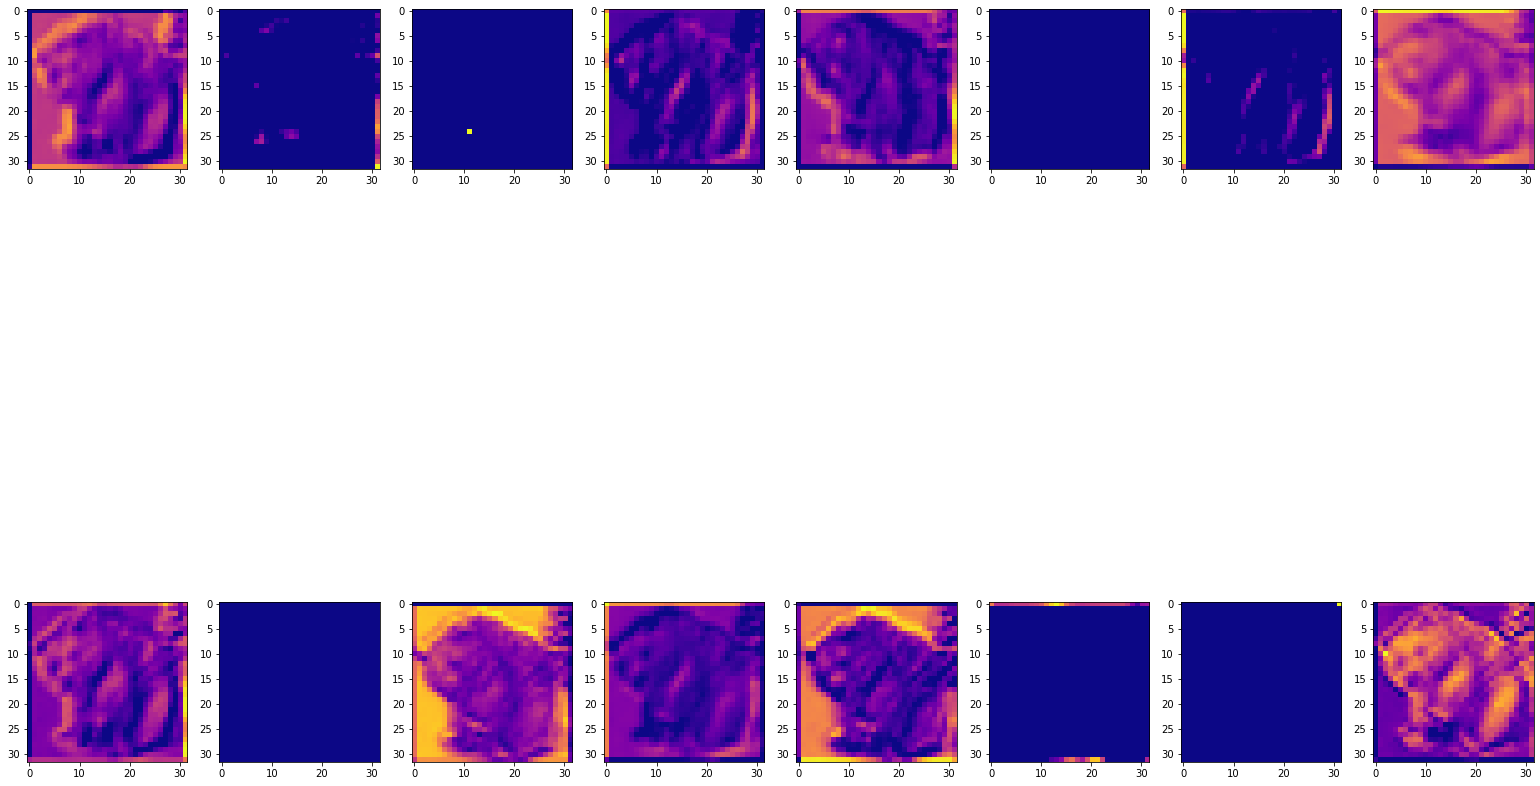

In [747]:
display_activation(activations, 8, 2, 0) # 1ère convolution

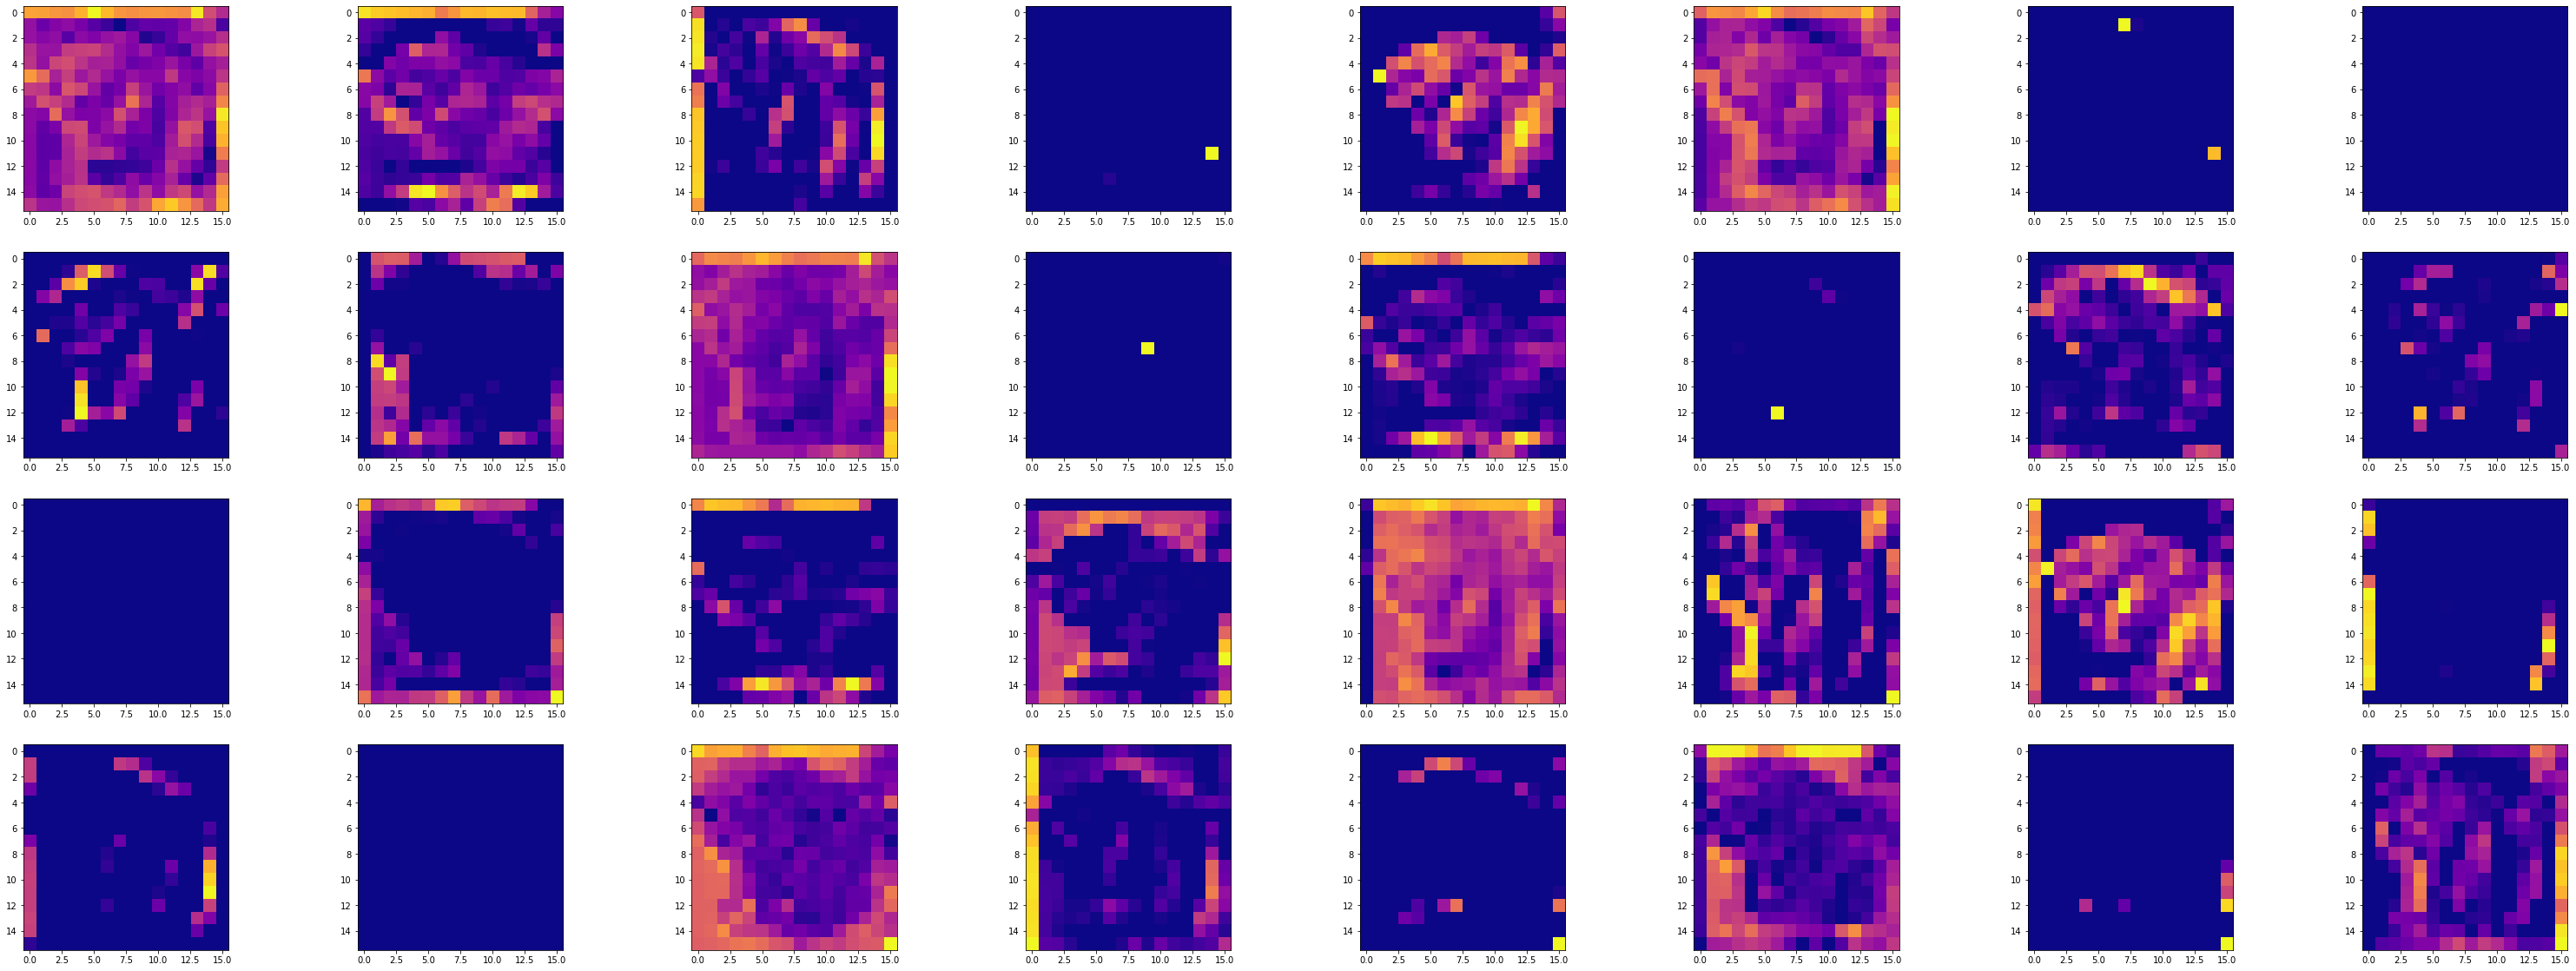

In [748]:
display_activation(activations, 8, 4, 3) # 2ème convolution

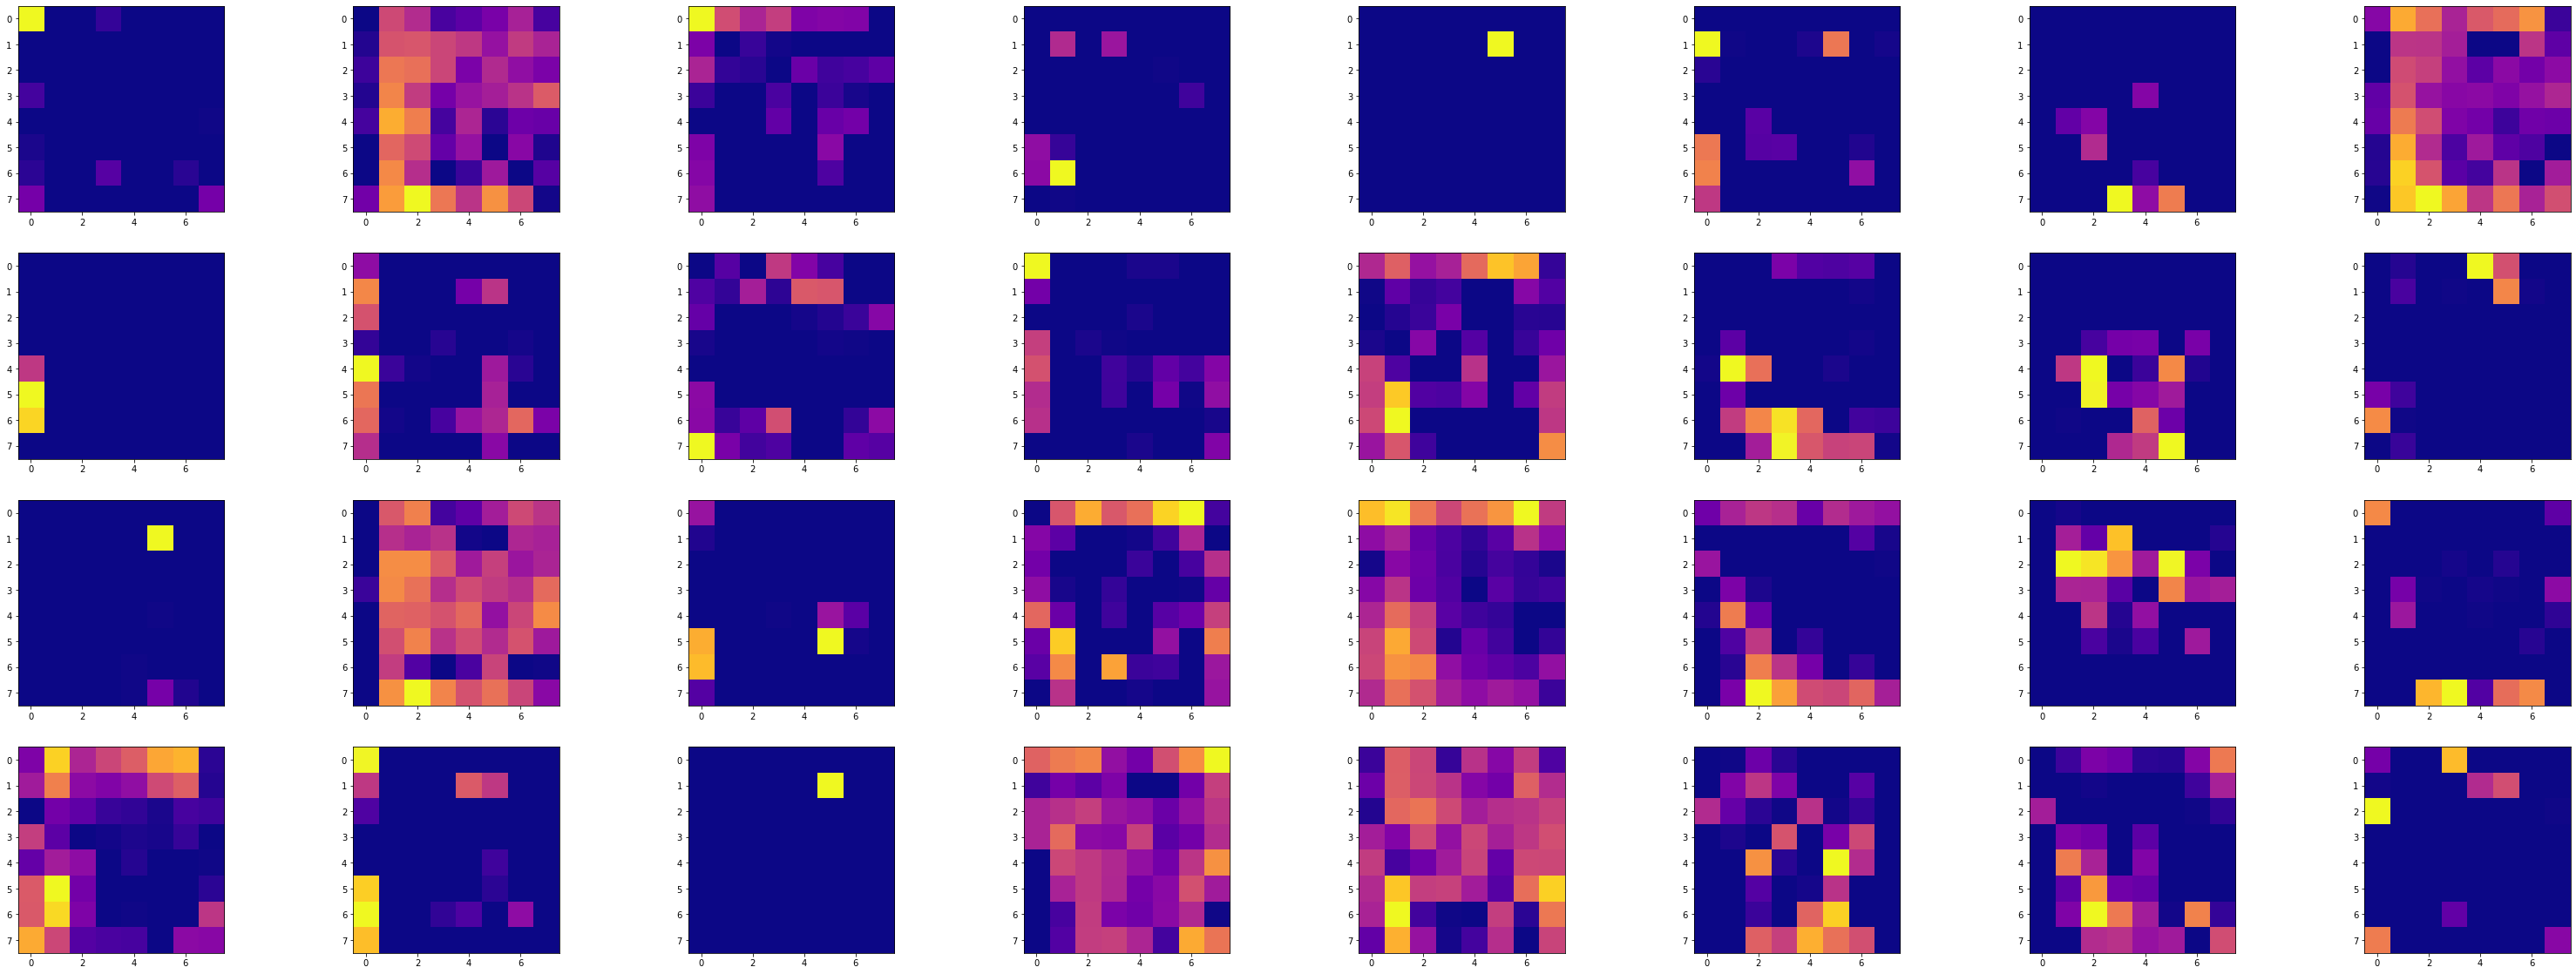

In [749]:
display_activation(activations, 8, 4, 7) # 3ème convolution

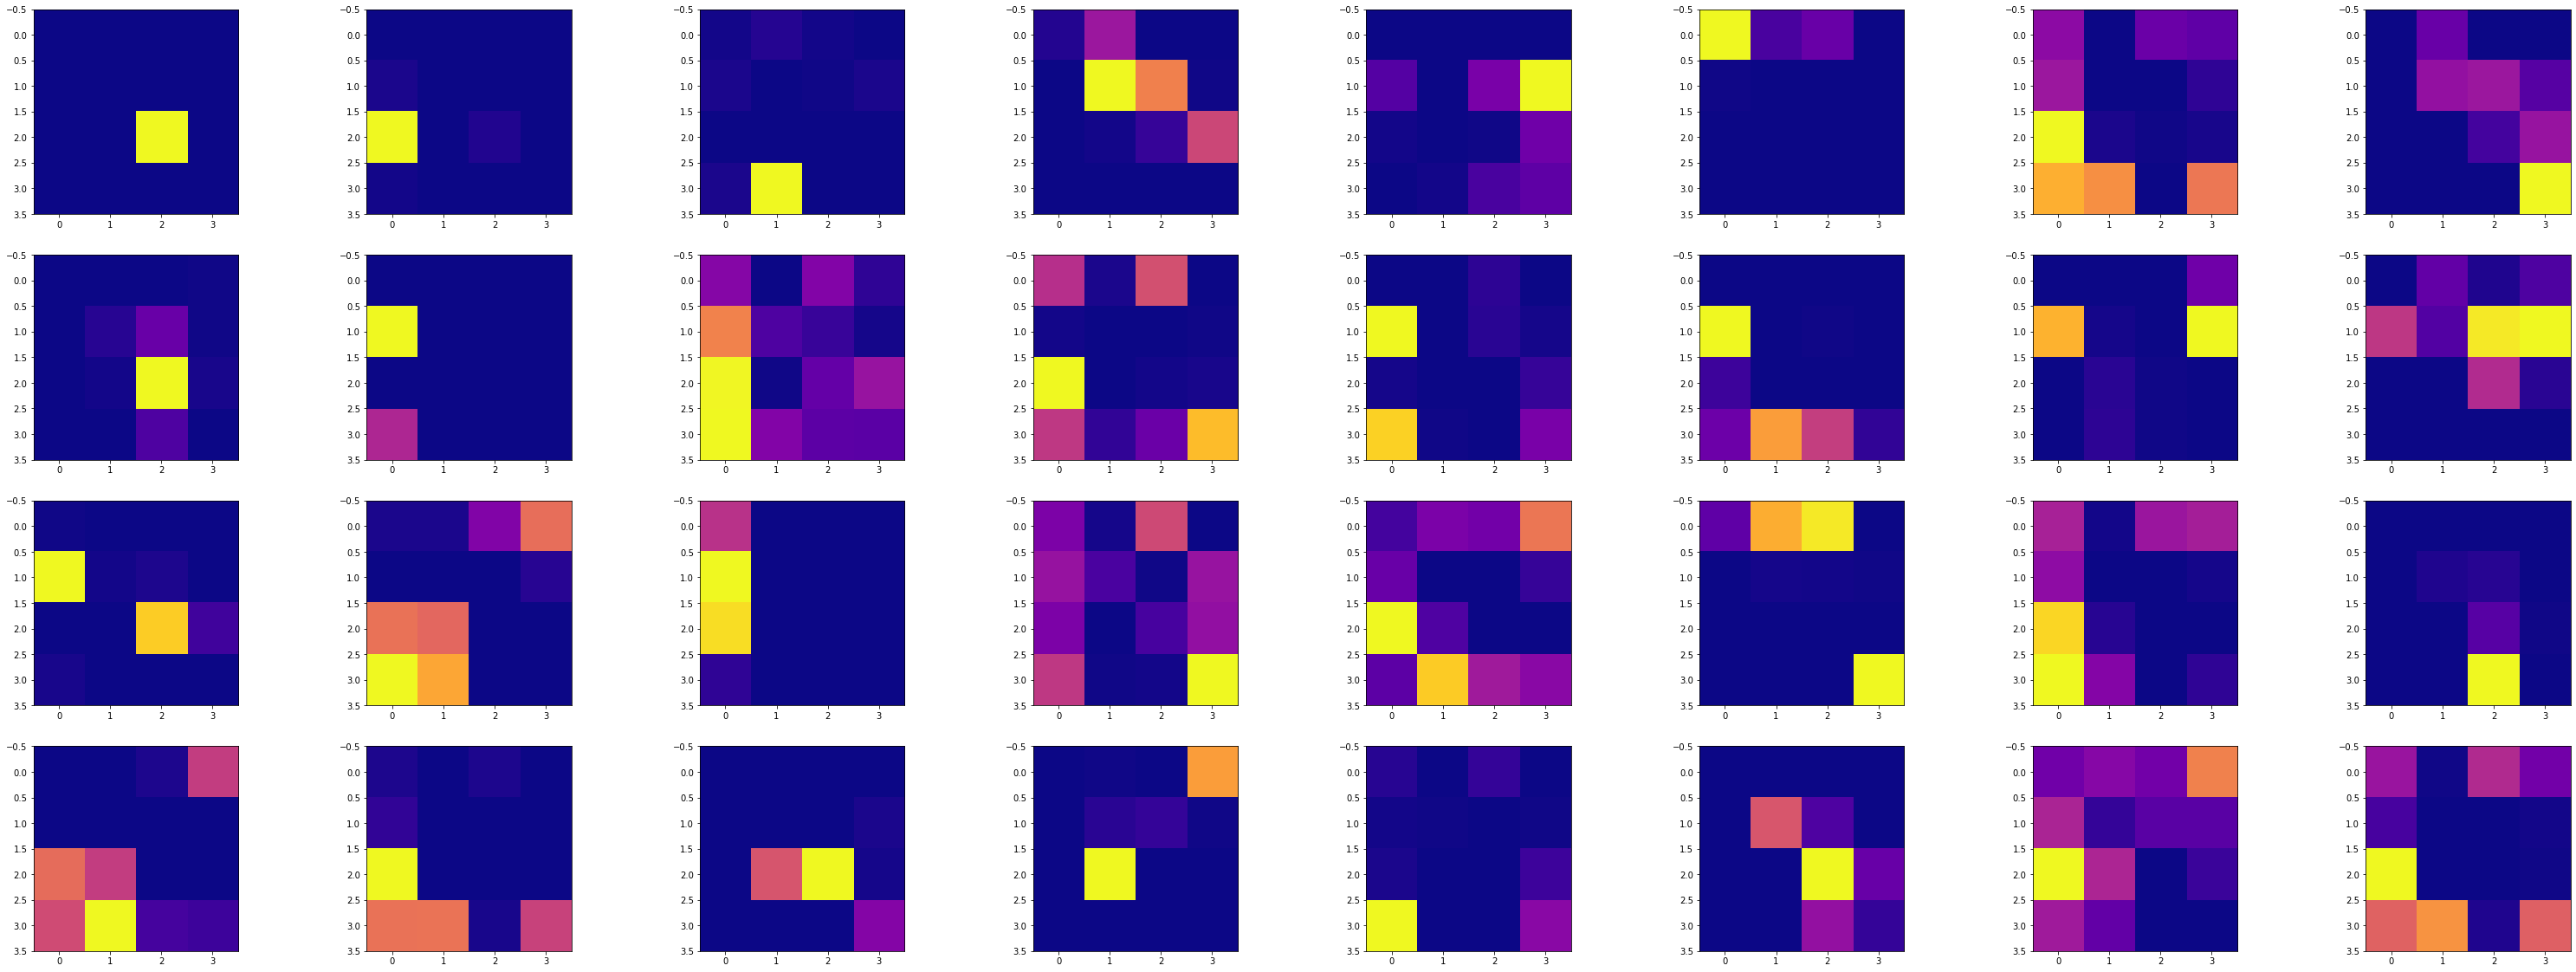

In [750]:
display_activation(activations, 8, 4, 10) # 4ème convolution

In [751]:
# Sauvegarder le modèle
# model.save('model_maxime.h5')

In [752]:
# Initialisation du tableau des labels
labels_array = os.listdir(TRAIN_DATA_DIR)

In [753]:
from tensorflow.keras.models import load_model

choix = r'./data-exploration/validation/bébé-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "baby". probs=  80.84220886230469


In [754]:
choix = r'./data-exploration/validation/tank-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "tank". probs=  99.94432330131531


In [755]:
choix = r'./data-exploration/validation/castor-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "beaver". probs=  56.17029666900635


In [756]:
choix = r'./data-exploration/validation/ours-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "bear". probs=  99.98251795768738


In [757]:
choix = r'./data-exploration/validation/poisson-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "aquarium_fish". probs=  76.98242664337158


In [758]:
choix = r'./data-exploration/validation/pomme-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "apple". probs=  68.49244236946106


In [759]:
choix = r'./data-exploration/validation/lit-1.png'

test_model = load_model('model_maxime.h5')

test_image = image.load_img(choix, target_size = (32, 32))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = test_model.predict(test_image)

preds = test_model.predict_classes(test_image)
prob = test_model.predict_proba(test_image)


index = preds[0]
print(f'Cet objet est un(e) "{labels_array[index]}".', 'probs= ', prob[0][index] * 100)

Cet objet est un(e) "bed". probs=  79.02706861495972
